# Introduksjon til PCA (principal component analysis)

Principal component analysis er en matematisk metode som er mye brukt innen
maskinlæring. I tilfeller der det er *korrelasjon* mellom noen av observasjonene i
datasettet, er det mulig å bruke PCA for å representere datasettet på en mer kompakt
måte. Dette sparer lagringsplass, gjør det enklere å visualisere datasettet, og man kan unngå den såkalte ["curse of
dimensionality"](https://en.wikipedia.org/wiki/Curse_of_dimensionality).  

Dersom datasettet representerer målinger med noe tilfeldig støy, kan PCA også brukes for
å skille støyen fra det nyttige signalet.

Vi starter med å importere modulene vi trenger:

In [1]:
# Imports
import numpy as np  # For vectors and matrices
import matplotlib.pyplot as plt

### Eksempel-datasett: Høyde og vekt
La oss bruke høyde og vekt på mennesker som et eksempel på data som kan måles. Disse to
størrelsene er *ikke* statistisk uavhengige - en person som er lang er vanligvis tyngre
enn en person som er kort. Høyde og vekt er positivt korrelert.

Vi genererer et datasett med høyde- og vektverdier. Datasettet er basert på en enkelt lineær
sammenheng, men vi legger til tilfeldige verdier for å få en realistisk variasjon i datasettet.

In [2]:
# Generate random height values centered around 170 cm
np.random.seed(13)  # Fixed seed to generate same numbers every time
height = np.random.normal(loc=170, scale=20, size=200)

# Use a simple linear model to create weight values
weight = -77 + 0.87 * height

# Add some randomness to the weight values
weight += np.random.normal(0, scale=6, size=height.shape)

Text(0, 0.5, 'Weight (kg)')

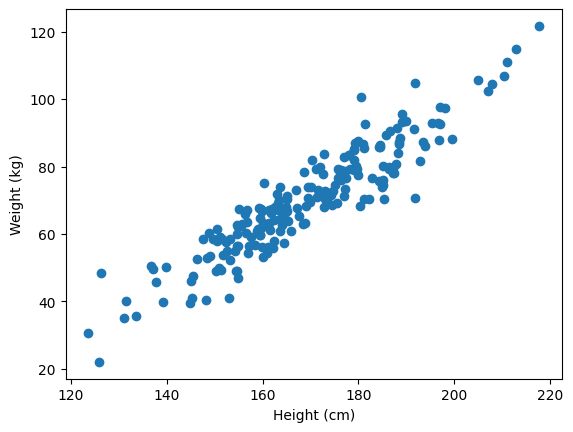

In [3]:
# Plot weight as function of height
_ = plt.scatter(height, weight)
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")

Høyde og vekt er nå to arrays som begge har lengde 200:

In [4]:
print(f"{height.shape=}")
print(f"{weight.shape=}")

height.shape=(200,)
weight.shape=(200,)


Vi kombinerer de to arrayene til en matrise $X$. Høyde tilsvarer første kolonne i matrisa,
og vekt tilsvarer andre kolonne.

In [5]:
# Concatenate into matrix -> array with shape (2,200)
X = np.concatenate([np.atleast_2d(height), np.atleast_2d(weight)])

# Transpose to make features correspond to column vectors (standard)
X = X.T
print(f"{X.shape=}")

X.shape=(200, 2)


### PCA - motivasjon
Vi så tidligere at vi kan plotte datasettet vårt som
"punkter i rommet" - vi kaller det også ofte "datapunkter". Noe av tanken bak PCA er at
man representere datapunktene i et nytt, *rotert* koordinatsystem som er bedre tilpasset
fordelingen av datapunktene. Vi prøver å tegne dette
opp for å ha en idé. Her definerer vi det roterte koordinatsystemet "manuelt". Etterpå
skal vi finne dette basert på datapunktene.

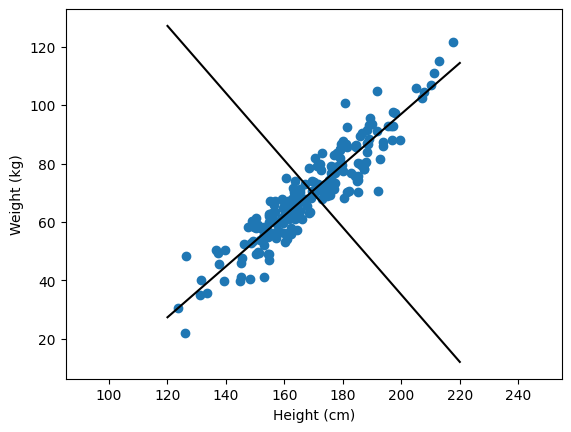

In [6]:
# Plot weight as function of height
_ = plt.scatter(height, weight)
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")

# Manually add rotated "axes" (these will be estimated from data later)
x_h = np.linspace(120, 220)
y_ax1 = -77 + 0.87 * x_h
y_ax2 = 265 - x_h / 0.87
plt.plot(x_h, y_ax1, c="k")
plt.plot(x_h, y_ax2, c="k")
_ = plt.gca().axis("equal")

Legg merke til at den mest vesentlige informasjonen om en person nå kan oppsummeres
gjennom hvor den befinner seg på aksen som går fra nedre venstre hjørne til øvre høyre
hjørne. Dette tilsvarer en slags komprimert observasjon om "høyde-vekt" som kan
representeres med ett enkelt tall, heller enn to (dvs. høyde + vekt). Posisjonen langs
den andre aksen beskriver på en måte et slags "avvik fra det typiske".  

Vær obs på at dette eksempelet har kun 2 "features" fordi det gjør det
enkelt å visualisere som punkter på en 2-dimensjonalt plan - men i praksis kan datasett
ha et villkårlig antall features $N$, der $N$ kan være 1, 2, 3, eller flere tusen, for
den del. Hver datapunkt befinner seg da i det N-dimensjonale rommet, og det fungerer på
samme måte som for 2 dimensjoner, men lar seg ikke alltid visualisere på en enkel måte. 

### PCA - relasjon til kovarians
I PCA ønsker man å finne ut hvilke retninger i "datarommet" som tilsvarer størst
*varians*. I vårt eksempel over tilsvarer det retningen til aksen fra nedre venstre til
øvre høyre hjørne. Denne informasjonen kan man finne gjennom å beregne
[kovarians-matrisen](https://en.wikipedia.org/wiki/Covariance_matrix) til datasettet. 

Kovarians-matrisen $\mathbf{S}$ for et datasett med $N$ features er en kvadratisk $N$ x $N$ matrise,
der elementet i rad $i$ og kolonne $j$ tilsvarer kovariansen mellom feature $i$ og
feature $j$:

$$\mathbf{S}_{i,j} = E[(\mathbf{x}_i - \mu_i) \cdot (\mathbf{x}_j - \mu_j)]$$

Merk at man trekker fra gjennomsnittsverdiene ($\mu_i$ og $\mu_j$). Uttrykkene i hver av
parantesene tilsvarer "avvik fra gjennomsnittet". La oss bruke eksempelet med høyde og
vekt for å forstå kovarians: Hvis vi har en høyde $\mathbf{x}_0$ som er større enn
gjennomsnittet, vil "avvik fra gjennomsnitt" $(\mathbf{x}_0 - \mu_0)$ være positivt. Da
kan vi også forvente at vekten $\mathbf{x}_1$ vil være større enn gjennomsnittsvekten,
dvs. at $(\mathbf{x}_1 - \mu_1)$ også vil være positiv. Hvis man multipliserer disse to
avvikene, vil man forvente å få et positivt tall. Høyde og vekt er positivt korrelert,
og en positiv kovarians vil uttrykke dette. Størrelsen på kovariansen beskriver hvor
sterk denne sammenhengen er.  

Andre størrelser kan gi en negativ kovarians. Et eksempel kunne være temperatur og
strømforbruk - lavere temperatur vil gi høyere strømforbruk.

I praksis regnes verdiene i kovarians-matrisa ut basert på datasettet ([sample covariance matrix](https://en.wikipedia.org/wiki/Sample_mean_and_covariance#Definition_of_sample_covariance)):

$$\mathbf{S}_{i,j} = \frac{1}{M-1} \sum_{k=0}^{M-1} (x_{k,i} - \mu_i) \cdot (x_{k,j} -
\mu_j)$$

der $M$ er antall samples (antall personer i vårt eksempel), $k$ er radindeks (sample
index) i $X$-matrisa, og $i$ og $j$ er kolonneindekser for ulike features. 

For bruk i PCA ønsker vi å bruke "sentrerte" x-verdier, dvs. verdier der
gjennomsnittsverdien allerede er trukket fra:

$$\hat{x}_{k,i} = x_{k,i} - \mu_i$$

og uttrykket for kovariansen blir da forenklet til 

$$\mathbf{S}_{i,j} = \frac{1}{M-1} \sum_{k=0}^{M-1} \hat{x}_{k,i} \cdot \hat{x}_{k,j} $$

NumPy har en innebygget metode for å beregne kovariansen:


In [7]:
# Calculate mean for each column, and "centered" values
X_mean = np.mean(X, axis=0)
print(f"{X_mean=}")
X_centered = X - X_mean

# Calculate covariance
S = np.cov(
    X_centered, rowvar=False
)  # rowvar = False: Features er orgainsert kolonnevis
print(f"{S=}")

X_mean=array([169.12891783,  70.13870264])
S=array([[310.29146485, 267.37832767],
       [267.37832767, 266.83764261]])


Verdiene 310.29146485 og 266.83764261 tilsvarer variansen ("selv-kovariansen") til
henholdsvis høyde og vekt. De to identiske verdiene 267.37832767 tilsvarer kovariansen
mellom høyde og vekt. Vi kan se fra uttrykket for kovarians at disse
nødvendigvis må bli like ($\mathbf{S}_{j,i}$ = $\mathbf{S}_{i,j}$). Kovariansmatrisa er
alltid [symmetrisk](https://en.wikipedia.org/wiki/Symmetric_matrix).

### PCA - Egenverdier og -vektorer
For å finne ut hvilke retninger i det N-dimensjonale "data-rommet" som har størst
varians kan vi finne egenverdiene og egenvektorene til kovariansmatrisa. Vi skal ikke gå
inn på all teorien bak disse konseptene, men fokusere på hva det gir oss. Vi
beregner egenvektorene $\mathbf{v}_i$ og egenverdiene $\lambda_i$ for kovariansmatrisa $\mathbf{S}$:

- Egenvektorene $\mathbf{v}_i$ representerer vektorer i data-rommet. Vektorene er
  *ortogonale* (de står vinkelrett på
  hverandre, på samme måte som f.eks. x- og y-aksen i et 2-dimensjonalt rom), og er
  *enhetsvektorer* ($|\mathbf{v}_i|=1$).
- Egenverdiene $\lambda_i$ representerer hvor mye varians datasettet har langs
  retningene som egenvektorene peker i. Vi kan bruke egenverdiene til å plukke ut de
  "viktigste" retningene, dvs. de som har størst varians.

Vi beregner $\lambda_i$ og $\mathbf{v}_i$ ved hjelp av NumPy:

In [8]:
eigenvalues, eigenvectors = np.linalg.eig(S)
# Note: Each column of eigenvectors corresponds to one eigenvector
for i in range(len(eigenvalues)):
    print(f"Eigenvector {eigenvectors[:,i]} has eigenvalue {eigenvalues[i]}")

Eigenvector [0.73518437 0.67786721] has eigenvalue 556.8241831524424
Eigenvector [-0.67786721  0.73518437] has eigenvalue 20.304924312364648


I eksempelet over kommer egenvektoren med størst egenverdi først, men det er ikke alltid
tilfelle. Vi kan sortere basert på egenverdi (største først, så synkende) basert på
følgende kode: 

In [9]:
# Create index for sorting
index = np.argsort(eigenvalues)[
    ::-1
]  # Syntax [::-1] reverses array, for descending values
print(f"{index=}")

# Sort vectors and values according to index
eigenvalues = eigenvalues[index]
eigenvectors = eigenvectors[:, index]

index=array([0, 1], dtype=int64)


La oss visualisere disse vektorene sammen med datasettet de ble generert fra:

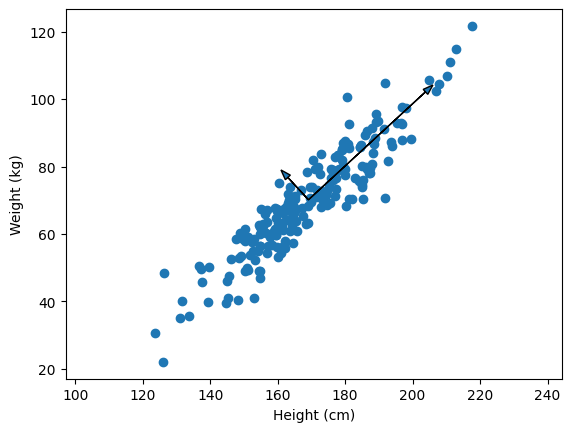

In [10]:
# Plot weight as function of height
_ = plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")

# Plot eigenvectors, centered at mean values
# Scale by sqrt(eigenvalue) mutiplied with fixed scale
scale = 2
for i in range(2):
    v_x = eigenvectors[0][i] * np.sqrt(eigenvalues[i]) * scale
    v_y = eigenvectors[1][i] * np.sqrt(eigenvalues[i]) * scale
    plt.arrow(x=X_mean[0], y=X_mean[1], dx=v_x, dy=v_y, head_width=2)
_ = plt.gca().axis("equal")

Tadaa! Vektorene peker langs de to "aksene" til fordelingen av datapunktene våre. Disse
to utgjør på en måte aksene i et nytt, rotert koordinatsystem. For å finne koordinatene
i dette nye koordinatsystemet skal vi *projisere* datapunktene våre langs egenvektorene.

### Projeksjon langs vektorer
For å skjønne projeksjon må vi repetere litt vektormatematikk. La oss ta utgangspunkt i
følgende figur fra [Wikipedia](https://en.wikipedia.org/wiki/Scalar_projection):

![Alt
text](https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/Projection_and_rejection.png/300px-Projection_and_rejection.png)

Vi har to vektorer $\mathbf{a}$ og $\mathbf{b}$. *Projeksjonen* av $\mathbf{a}$ langs
vektoren $\mathbf{b}$ er vist som $\mathbf{a}_1$. Dette kan tolkes som "hvor mye av
$\mathbf{a}$ peker i samme retning som $\mathbf{b}$". Lengden av projeksjonen er gitt
ved

$$|\mathbf{a}_1| = \frac{\mathbf{a} \cdot \mathbf{b}}{|\mathbf{b}|}$$ 

det vil si prikkproduktet mellom $\mathbf{a}$ og $\mathbf{b}$, delt på lengden av
vektoren $\mathbf{b}$. I spesialtilfellet at $\mathbf{b}$ er en *enhetsvektor*, dvs.
$|\mathbf{b}| = 1$, får vi den forenklede formelen

$$|\mathbf{a}_1| = \mathbf{a} \cdot \mathbf{b} \quad (\text{gitt } |\mathbf{b}| = 1)$$ 

Heldigvis for oss er egenvektorene som vi regnet ut tidligere akkurat slike
enhetsvektorer.

### PCA - projeksjon langs egenvektorer

La oss nå ta for oss en enkelt person som er 140 cm lang og veier 65 kg (dvs. han er
ganske tung relativt til sin lengde). La oss kalle ham "Gimli". Vi beskriver ham som en
vektor med høyde og vekt, og regner også ut en "sentrert versjon" (gjennomsnitt trukket fra).

In [11]:
gimli = np.atleast_2d(np.array([140, 65], dtype=float))
print(f"{gimli=}")

gimli_centered = gimli - X_mean
print(f"{gimli_centered=}")


gimli=array([[140.,  65.]])
gimli_centered=array([[-29.12891783,  -5.13870264]])


Vi plotter Gimli sammen med resten av datasettet (også "sentrert"):

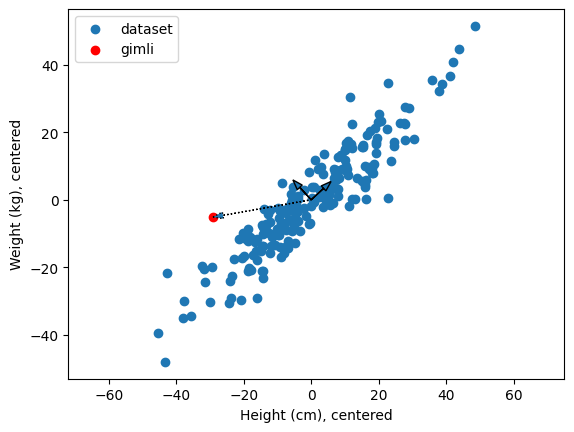

In [12]:
# Plot weight as function of height
_ = plt.scatter(X_centered[:, 0], X_centered[:, 1], label="dataset")
plt.xlabel("Height (cm), centered")
plt.ylabel("Weight (kg), centered")

# Plot eigenvectors
scale = 5
for i in range(2):
    v_x = eigenvectors[0][i] * scale
    v_y = eigenvectors[1][i] * scale
    plt.arrow(x=0, y=0, dx=v_x, dy=v_y, head_width=2)

plt.scatter(gimli_centered[0, 0], gimli_centered[0, 1], c="r", label="gimli")
plt.arrow(
    x=0,
    y=0,
    dx=gimli_centered[0, 0],
    dy=gimli_centered[0, 1],
    head_width=2,
    length_includes_head=True,
    linestyle=":",
)

plt.legend()
_ = plt.gca().axis("equal")

I plottet over er også enhetsvektorene som vi fant tidligere plottet inn. De har
egentlig lengde 1, men er skalert litt opp for å vises bedre. For å finne projeksjonen
av Gimli langs disse to vektorene, dvs. hans koordinater i det nye, roterte
koordinatsystemet, kan vi ta prikkproduktet, slik vi så tidligere: 

In [13]:
gimli_pca_0 = gimli_centered @ eigenvectors[:, 0]  # Dot product with first vector
gimli_pca_1 = gimli_centered @ eigenvectors[:, 1]  # Dot product with second vector
print(f"{gimli_pca_0=}")
print(f"{gimli_pca_1=}")

gimli_pca_0=array([-24.89848296])
gimli_pca_1=array([15.96764431])


Her ser vi at Gilmis nye "PCA-koordinater" er -24.9 langs den første aksen, som vi kan
tenke på som den kombinerte "høyde-vekt-aksen", og 15.9 langs den andre aksen, som vi
kan tenke på som "vekt-relativt-til-høyde-aksen". I koden over regnet vi ut disse to
verdiene i to steg, men det er mulig å gjøre dem samtidig gjennom matrisemultiplikasjon:

In [14]:
gimli_pca = gimli_centered @ eigenvectors
print(f"{gimli_pca}")

[[-24.89848296  15.96764431]]


Vi kan gjøre det samme for hele datasettet også:

In [15]:
X_pca = X_centered @ eigenvectors
print("First 5 datapoints of PCA transformed X matrix:")
print(f"{X_pca[0:5,:]}")


First 5 datapoints of PCA transformed X matrix:
[[-14.69672445   3.79414878]
 [ 18.43534844  -3.53023392]
 [ -1.26403699  -1.34291913]
 [ 13.29742343  -0.19365319]
 [ 32.46019057  -5.76645648]]


Vi plotter det transformerte datasettet og Gimli:

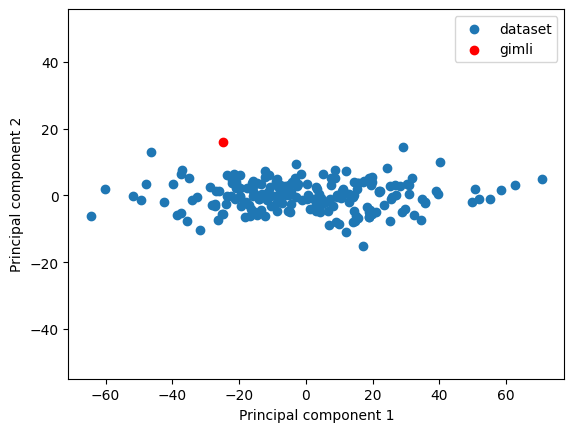

In [16]:
# Plot weight as function of height
_ = plt.scatter(X_pca[:, 0], X_pca[:, 1], label="dataset")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

plt.scatter(gimli_pca[0, 0], gimli_pca[0, 1], c="r", label="gimli")

plt.legend()
_ = plt.gca().axis("equal")

Her ser vi datapunktene i et transformert koordinatsystem, der x-aksen tilsvarer den
dominante "høyde-vekt" retningen som vi så tidligere. Aksene i det nye koordinatsystemet
kalles "principal components" og er nummerert fra 1 og oppover. 

I noen tilfeller er vi ikke interesserte i å bruke alle komponentene - det er nok å
bruke de første, dvs. de som utgjør størst varians i datasettet. Hvis vi for eksempel
bare vil ha den første av to principal components (x-koordinat i plottet over), kan vi bruke bare den første egenvektoren:

In [17]:
n_components = 1
eigenvectors_limited = eigenvectors[:, 0:n_components]
X_pca_limited = X_centered @ eigenvectors_limited

print(f"{eigenvectors_limited=}")
print(f"{X_pca_limited[0:5]=}")

eigenvectors_limited=array([[0.73518437],
       [0.67786721]])
X_pca_limited[0:5]=array([[-14.69672445],
       [ 18.43534844],
       [ -1.26403699],
       [ 13.29742343],
       [ 32.46019057]])


### Datasett med flere enn 2 dimensjoner
I eksempelet over brukte vi bare 2 features, høyde og vekt, siden det er enkelt å
visualisere. Metoden er stort sett lik dersom man har flere dimensjoner, men man vil få
større kovariansmatrise, og flere egenvektorer og -verdier. Vi tar med et kort eksempel
her, der vi genererer 10 "samples" av 4 features (4-dimensjonalt datasett):

In [18]:
X_4d = np.random.multivariate_normal(
    mean=[0, 0, 0, 0],
    cov=[[1, 0.7, 0, 0], [0.7, 1, 0.2, 0], [0, 0.2, 1, 0], [0, 0, 0, 1]],
    size=10,
)

In [19]:
X_4d.shape
print(X_4d)

[[ 0.46765168  0.00812229 -0.36957482  1.27512584]
 [ 0.80140167  0.50132523 -0.59875266 -2.23305285]
 [-0.86507011 -0.16225394 -1.40307911  0.44976721]
 [-0.58110023 -1.30076284  0.39053222 -0.45896717]
 [ 2.69756841  1.51019493 -1.55749602  0.900085  ]
 [ 0.41467273  0.05318092 -0.61434511  0.61295507]
 [ 1.80713353  1.05851451  0.05383126  0.25322052]
 [-0.82687241  0.16119618 -0.51659439  0.16872106]
 [ 1.78929494  1.55659575  0.62596345 -0.70460476]
 [ 0.93753957  1.13277762  0.8555257   0.70618881]]


Kovariansmatrisa $S$ for et slikt datasett ville hatt størrelse 4x4 (siden det er 4
kolonner i datasettet). Kovariansmatrisa ville hatt 4 egenvektorer og 4 egenverdier.
Hvis man ville beholde f.eks. kun koordinatene for de 2 "viktigste" egenvektorene, kunne
man sortere egenvektorene etter egenverdiene (største først), og bruke kun de 2 første.